## AlekseevDP(DSU-4,DLL-15)_HW#11_Компьютерное_зрение(Часть_3)

## Задание:
- Возьмите MNIST, обучите на нем сетку (LeNet)
- Возьмите какую-нибудь картинку (из mnist’а)
- Обучите шум, который при добавлении к оригинальной картинке заставит ее ошибаться в пользу другого класса

## Для решения задачи были частично использованы следующие материалы:
- LeNet Model definition: https://github.com/pytorch/examples/blob/main/mnist/main.py
- Реализация атаки методом "The Fast Gradient Sign Method (FGSM)": https://adversarial-ml-tutorial.org/adversarial_examples/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Опишем структуру сети в архитектуре LeNet

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

## Скачаем MNIST и сформируем загрузчики трейн- и тест- выборок

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Обучим сеть 

In [6]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [7]:
model_LeNet = LeNet().to(device)
model_LeNet

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
opt = optim.Adadelta(model_LeNet.parameters(), lr=0.1)

for _ in range(15):
    train_err, train_loss = epoch(train_loader, model_LeNet, opt)
    test_err, test_loss = epoch(test_loader, model_LeNet)
    print(*("{:.3f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.165	0.534	0.087	0.283
0.066	0.226	0.046	0.156
0.044	0.151	0.037	0.119
0.034	0.116	0.029	0.101
0.029	0.098	0.027	0.088
0.026	0.085	0.026	0.086
0.024	0.080	0.022	0.073
0.021	0.071	0.020	0.069
0.020	0.066	0.022	0.066
0.019	0.063	0.023	0.068
0.018	0.062	0.019	0.059
0.018	0.060	0.019	0.065
0.017	0.059	0.021	0.068
0.017	0.054	0.018	0.056
0.016	0.053	0.019	0.063


In [9]:
torch.save(model_LeNet.state_dict(), "model_LeNet.pt")

In [ ]:
# model_LeNet.load_state_dict(torch.load("model_LeNet.pt"))

## Реализуем атаку на сеть методом "The Fast Gradient Sign Method (FGSM)":

In [10]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [11]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

## Покажем "оригинальные" предсказания (на обученной НС, до реализации атаки)

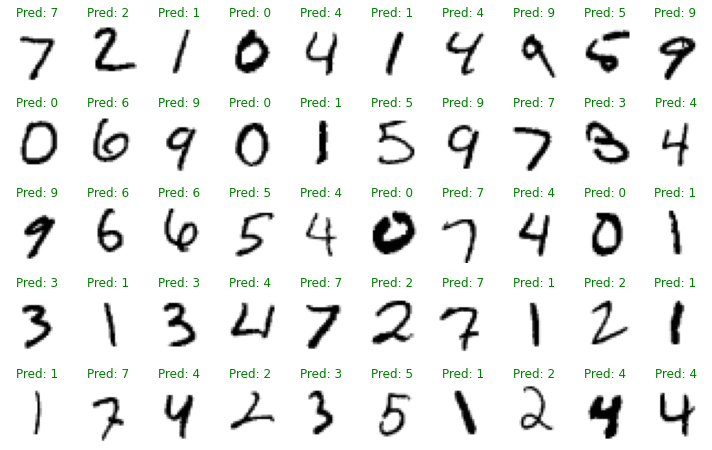

In [12]:
yp = model_LeNet(X)
plot_images(X, y, yp, 5, 10)

## Покажем изменение предсказаний сетью после реализации атак методом FGSM (с разными значениями Epsilon).

## а) Epsilon = 0 -> фактическое отсутствие атаки (шум не вносится). -> Значения предсказываются сетью с точностью, полученной на этапе обучения):

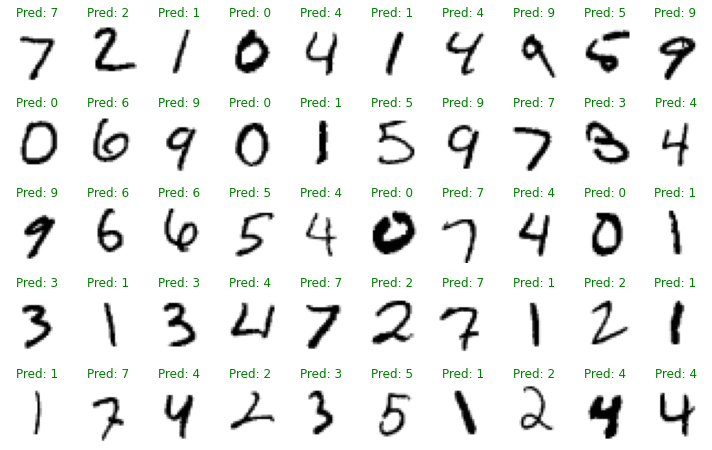

In [13]:
noise = fgsm(model_LeNet, X, y, 0)
yp = model_LeNet(X + noise)
plot_images(X+noise, y, yp, 5, 10)

## б) Epsilon = 0.1 -> Точность предсказаний падает, но не слишком существенно:

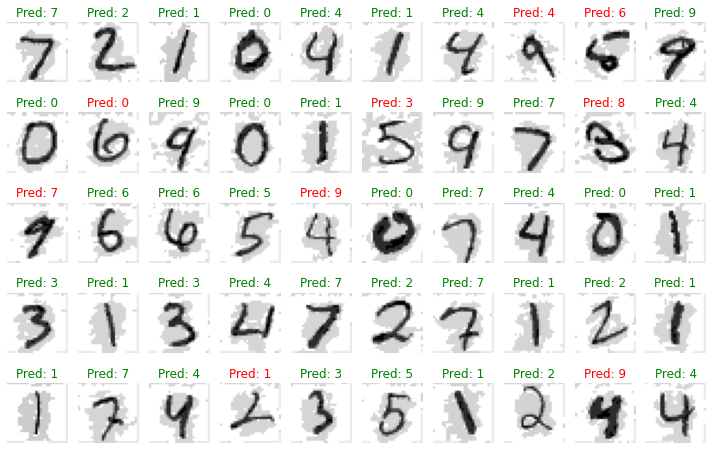

In [14]:
noise = fgsm(model_LeNet, X, y, 0.1)
yp = model_LeNet(X + noise)
plot_images(X+noise, y, yp, 5, 10)

## в) Epsilon = 0.2 -> Точность предсказаний катастрофически падает: 

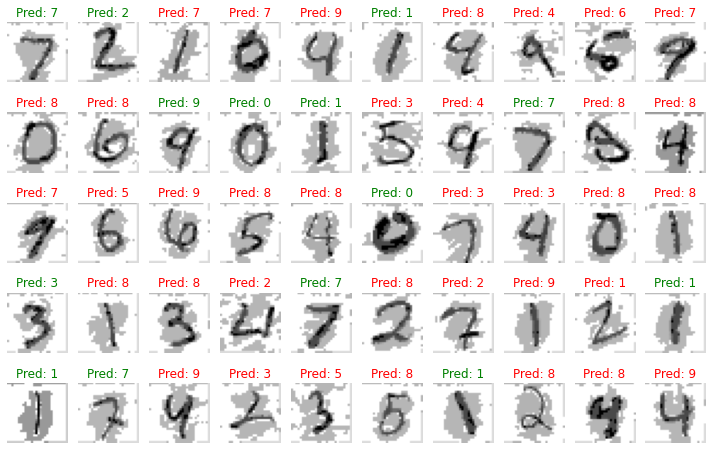

In [15]:
noise = fgsm(model_LeNet, X, y, 0.2)
yp = model_LeNet(X + noise)
plot_images(X+noise, y, yp, 5, 10)

## г) Epsilon = 0.3 -> Предсказания практически полностью искажены внесенным шумом, хотя визуально всё ещё угадываются очертания "правильных" цифр: 

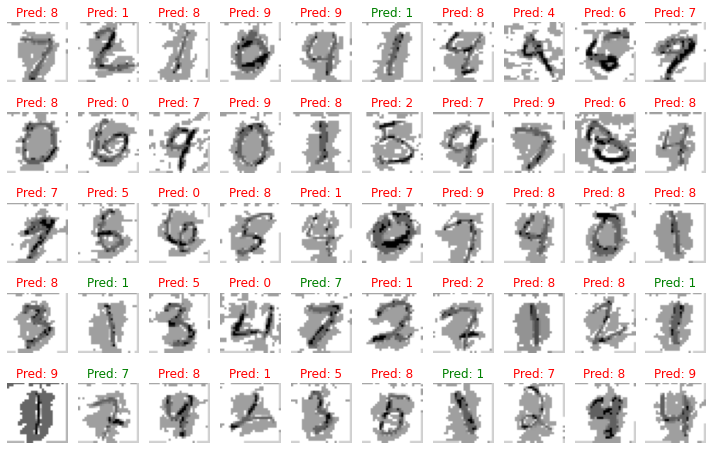

In [16]:
noise = fgsm(model_LeNet, X, y, 0.3)
yp = model_LeNet(X + noise)
plot_images(X+noise, y, yp, 5, 10)

## Выведем маски шума, полученные для последнего случая (Epsilon=0.3):

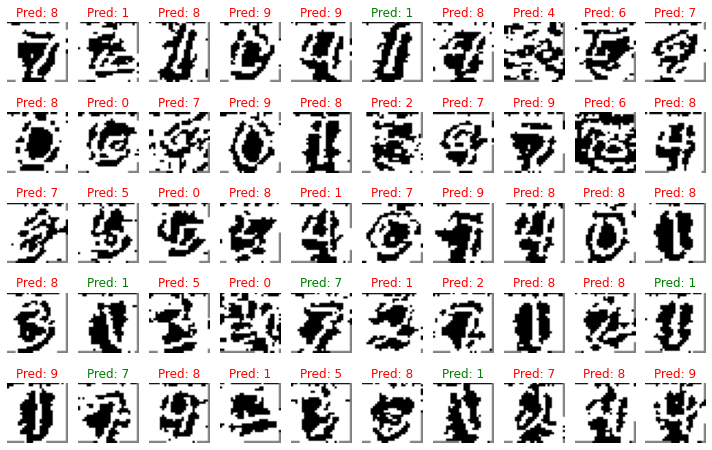

In [17]:
plot_images(noise, y, yp, 5, 10)